In [294]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
import numpy.ma as ma
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity


class KNNRec():
    """
    Sources used to build recommender:
    
    https://github.com/NicolasHug/Surprise/blob/f98907f84251e88f96669eb29284bd7976a8eecc/surprise/prediction_algorithms/knns.py
    
    https://github.com/benlindsay/movielens-analysis/blob/master/03_Similarity-based_CF.ipynb
    
    http://files.grouplens.org/papers/FnT%20CF%20Recsys%20Survey.pdf
    """
    def __init__(self,k=20,mode="user",similarity_func="cosine",damping_factor=10):

        
        self.mode = mode
        self.similarity_func = similarity_func
        self.R = None
        self.mu = None
        self.num_items = None
        self.num_users = None
        self.k = k
        self.damping_factor = damping_factor
        self.M = None
        self.sim_M = None
        self.movies = None
        self.users = None
        self.nearest_neighbors = {}
    
    def _create_movie_user_matrix(self):
        self.M = pd.pivot_table(
                data=self.R,
                values="rating",
                index="userId",
                columns="movieId")
        
        self.movies = self.M.columns
        self.users = self.M.index

    def _compute_k_nearest_neighbors(self):
        
        
        self._compute_similarity()
        
        if self.mode == "item":
            df = pd.DataFrame(self.sim_M,columns=self.movies,index=self.movies)
        else:
            df = pd.DataFrame(self.sim_M,columns=self.users,index=self.users)
        for col in df:
            self.nearest_neighbors[col] = df[col].nlargest(self.k)
        

        
    def fit(self,X,y):
        self.R = X.copy()
        self.R["rating"] = y.copy()
        
        self._create_movie_user_matrix()
        
        self.num_users, self.num_items = self.M.shape
        self.mu = self.R["rating"].mean()
        
        self.baseline_predictor()
        
        self.R = self.create_baseline(self.R)
        
        self.R["normalized_rating"] = self.R["rating"]-self.R["baseline"]
        self._compute_k_nearest_neighbors()

    
        return self

    
    def baseline_predictor(self):
        num_ratings_per_movie = self.R["movieId"].value_counts()
        num_ratings_per_user = self.R["userId"].value_counts()
        sum_ratings_per_user = self.R.groupby("userId")["rating"].sum()
        sum_ratings_per_movie = self.R.groupby("movieId")["rating"].sum()
        
        self.b_u = (sum_ratings_per_user-(self.mu*num_ratings_per_user))/(num_ratings_per_user+self.damping_factor)
        
        X = self.R.join(self.b_u.rename('b_u'), on='userId')
        X['res'] = X['rating'] - X['b_u'] - self.mu
        num = X[['movieId', 'res']].groupby('movieId')['res'].sum()
        
        denom = num_ratings_per_movie+self.damping_factor
        
        self.b_m = num/denom
    
    def create_baseline(self,X):
        X = X.copy()
        single_baseline = lambda user,movie: self.b_u[user]+self.b_m[movie]+self.mu
        
        X["baseline"] = X.apply (lambda row:single_baseline(row["userId"],row["movieId"]) , axis=1)
        return X

    def _compute_similarity(self,pearson_simil_threshold=50.0):

        if  self.similarity_func == 'cosine':
            
            df = self.M.fillna(0).values
            
            if self.mode == "user":
                self.sim_M = cosine_similarity(df)
            else:
                self.sim_M = cosine_similarity(df.T)
            
            np.fill_diagonal(self.sim_M, -2)

        
        if  self.similarity_func == "pearson":
            if self.mode == "user":
                df = self.M.T
            else:
                df = self.M
            
            corr_df = df.corr()
            
            df_common_idx = corr_df.copy()

            for col in corr_df:
                
                for i, row_value in corr_df[col].iteritems():
                    
                    user_a = col
                    user_b = i
                          
                    dif_nan_a = df.T.loc[user_a].notnull()
                    dif_nan_b = df.T.loc[user_b].notnull()

                    bool_arr = dif_nan_a & dif_nan_b

                    num_common = bool_arr.sum()
 
                    
                    df_common_idx[col][i] = corr_df[col][i]*min(num_common/pearson_simil_threshold,1)
 
                    
            self.sim_M = df_common_idx.values
            
            np.fill_diagonal(self.sim_M, -2)

    def predict_entity(self,user,movie,baseline):
        

        if self.mode == "user":
            N = self.nearest_neighbors[user]
            query = self.R.loc[(self.R.movieId == movie)&(self.R.userId.isin(N.index))].set_index("userId")
            
        else:
            N = self.nearest_neighbors[movie]
            query = self.R.loc[(self.R.userId == user)&(self.R.movieId.isin(N.index))].set_index("movieId")
        
        denom = N.abs().sum()
        
        numer = 0
        if query.size > 1:
            mult = N.multiply(query["normalized_rating"], fill_value=0)

            numer = mult.sum()

        ret  =  baseline + (numer/denom)
        return ret
        
        
    
    def predict(self,X):
        X = X.copy()
        self.mask = (X.userId.isin(self.users)) & (X.movieId.isin(self.movies))
        X_test = X.loc[self.mask]
        
        X_test = self.create_baseline(X_test)
        
        X_test["prediction"] = X_test.apply(lambda row:self.predict_entity(row["userId"],row["movieId"],row["baseline"]) , axis=1)
        
        return X_test
        
        
        

In [ ]:
while True:
    print("hello")

In [295]:
import pandas as pd
ratings = pd.read_csv("datasets_small/ratings.csv")
ratings = ratings.loc[:,["userId","movieId","rating"]]
ratings.head(10)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
5,1,70,3.0
6,1,101,5.0
7,1,110,4.0
8,1,151,5.0
9,1,157,5.0


In [338]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(ratings.drop(columns="rating"), ratings["rating"], test_size=0.30, random_state=42)

In [297]:
clf = KNNRec(k=30,mode="user",similarity_func="cosine")

In [398]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error,mean_absolute_error
import math
import time

def cross_val(X,y,model,n_folds=5,baseline=False):
    kf = KFold(n_splits=n_folds)
    total_err = 0
    count = 1
   
    for train_index, val_index in kf.split(X):
        t = 0
        start = time.time()
        
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model.fit(X_train,y_train)
        y_pred = model.predict(X_val)
        
        if baseline:
            err = math.sqrt(mean_squared_error(y_val.loc[model.mask], y_pred["baseline"]))
        else:
            err = math.sqrt(mean_squared_error(y_val.loc[model.mask], y_pred["prediction"]))
        
        total_err = total_err + err
        
        end = time.time()
        
        t = end - start
        print(f"fold={count},RMSE={err:5},time={t}")
        
        count += 1
    
    avg_err = total_err/n_folds
    print(f"Avg Error:{avg_err} RMSE")
   
    return avg_err




def grid_search(X_train,y_train,ks,mode="user",simil="cosine"):
    result_df = pd.DataFrame(columns=["k","mode","simil_func","RMSE"])
    for k in ks:
        model = KNNRec(k=k,mode=mode,similarity_func=simil)
        print(f"MODEL: k = {model.k}, mode = {model.mode}, simil_func={model.similarity_func}")
        error = cross_val(X_train,y_train,model,5)
        result_df = result_df.append({"k":k,"mode":mode,"simil_func":simil,"RMSE":error},ignore_index=True)
    return result_df

In [381]:
model = KNNRec(k=30,mode="user",similarity_func="cosine")
baseline_error = cross_val(X_train,y_train,model,5,baseline=True)

fold=1,RMSE=0.8791398534738206,time=40.669719219207764
fold=2,RMSE=0.8707878808871118,time=40.35366082191467
fold=3,RMSE=0.8839103028635259,time=40.791038513183594
fold=4,RMSE=0.8738358661720174,time=40.56242036819458
fold=5,RMSE=0.8950953304784929,time=40.20566415786743
Avg Error:0.8805538467749937 RMSE


In [351]:
df = grid_search(X_train,y_train,[5,10,15,20,25,30,35,40,45,50],mode="user",simil="pearson")

MODEL: k = 5, mode = user, simil_func=pearson
fold=1,RMSE=0.8794004188965975,time=569.9596955776215
fold=2,RMSE=0.8740184931786895,time=497.991126537323
fold=3,RMSE=0.8875514089551864,time=536.6043276786804
fold=4,RMSE=0.8767722306486853,time=527.302651643753
fold=5,RMSE=0.8966160287838403,time=456.29380536079407
Avg Error:0.8828717160925998 RMSE
MODEL: k = 10, mode = user, simil_func=pearson
fold=1,RMSE=0.872768193276233,time=463.2379469871521
fold=2,RMSE=0.8665117868316454,time=480.0887405872345
fold=3,RMSE=0.8803893586512868,time=489.2274467945099
fold=4,RMSE=0.8694284126043683,time=479.88776683807373
fold=5,RMSE=0.8897689831346318,time=475.13147592544556
Avg Error:0.8757733468996329 RMSE
MODEL: k = 15, mode = user, simil_func=pearson
fold=1,RMSE=0.87113845688041,time=496.1728904247284
fold=2,RMSE=0.8648406313953066,time=462.532457113266
fold=3,RMSE=0.8781002551745702,time=436.8544821739197
fold=4,RMSE=0.8681623590610501,time=438.23428297042847
fold=5,RMSE=0.8884359836294197,time=44

In [355]:
df1 = grid_search(X_train,y_train,[5,10,15,20,25,30,35,40,45,50],mode="user",simil="cosine")

MODEL: k = 5, mode = user, simil_func=cosine
fold=1,RMSE=0.8814126632522886,time=38.937382221221924
fold=2,RMSE=0.874946626696824,time=40.44405245780945
fold=3,RMSE=0.8868656534800418,time=39.18228721618652
fold=4,RMSE=0.875826957454024,time=39.32120203971863
fold=5,RMSE=0.8950112002973126,time=39.104339599609375
Avg Error:0.8828126202360982 RMSE
MODEL: k = 10, mode = user, simil_func=cosine
fold=1,RMSE=0.8754882062295044,time=42.36298394203186
fold=2,RMSE=0.8666259887558759,time=40.77037572860718
fold=3,RMSE=0.87968911917576,time=43.82011532783508
fold=4,RMSE=0.8704492120375511,time=43.77674198150635
fold=5,RMSE=0.8892403039382311,time=45.05391478538513
Avg Error:0.8762985660273845 RMSE
MODEL: k = 15, mode = user, simil_func=cosine
fold=1,RMSE=0.8734025043479062,time=46.32684063911438
fold=2,RMSE=0.865187842798326,time=58.34665012359619
fold=3,RMSE=0.877947705035684,time=54.24688267707825
fold=4,RMSE=0.8689664082803046,time=41.43543982505798
fold=5,RMSE=0.8878468411983903,time=41.7772

In [399]:
df2 = grid_search(X_train,y_train,[5,10,15,20,25,30,35,40,45,50],mode="item",simil="cosine")

MODEL: k = 5, mode = item, simil_func=cosine
fold=1,RMSE=0.8685063375281216,time=43.06587815284729
fold=2,RMSE=0.8603805845071547,time=43.30500793457031
fold=3,RMSE=0.8739515667529719,time=43.298444509506226
fold=4,RMSE=0.8639213368446822,time=44.84915089607239
fold=5,RMSE=0.8864549176772567,time=42.56832957267761
Avg Error:0.8706429486620374 RMSE
MODEL: k = 10, mode = item, simil_func=cosine
fold=1,RMSE=0.8661024503459758,time=45.53234314918518
fold=2,RMSE=0.8589862656972531,time=46.02713227272034
fold=3,RMSE=0.8716781211661985,time=44.79232668876648
fold=4,RMSE=0.861763316741404,time=44.1650505065918
fold=5,RMSE=0.8837829797006279,time=46.31634449958801
Avg Error:0.868462626730292 RMSE
MODEL: k = 15, mode = item, simil_func=cosine
fold=1,RMSE=0.8668812346483301,time=44.516982555389404
fold=2,RMSE=0.8590043566134261,time=43.57005786895752
fold=3,RMSE=0.8723393181296608,time=46.40334129333496
fold=4,RMSE=0.8614213479578091,time=45.67940306663513
fold=5,RMSE=0.8831780284653313,time=44.3

In [ ]:
df2 = grid_search(X_train,y_train,[4,8,12,16,20],mode="item",simil="pearson")

In [ ]:
df1 = df1.set_index("k")
df = df.set_index("k")

In [403]:
df2 = df2.set_index("k")

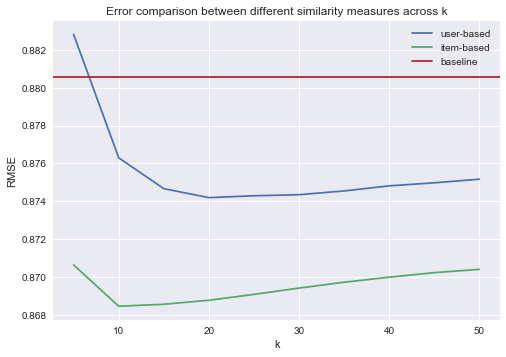

In [404]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use("seaborn")

df1.RMSE.plot(x="k",label="user-based")
df2.RMSE.plot(x="k",label="item-based")
plt.axhline(y=baseline_error,label="baseline",color="firebrick")
plt.legend()
# plt.ylim(0.873,0.876)
plt.ylabel("RMSE")
plt.title("Error comparison between different similarity measures across k");

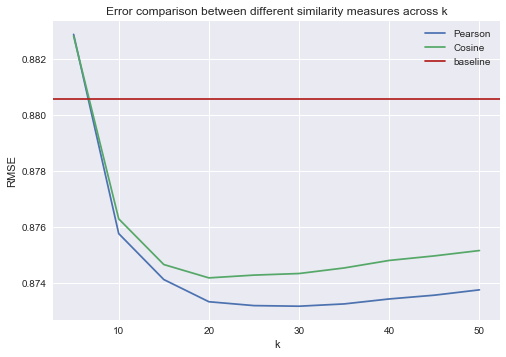

In [395]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use("seaborn")

df.RMSE.plot(x="k",label="Pearson")
df1.RMSE.plot(x="k",label="Cosine")
plt.axhline(y=baseline_error,label="baseline",color="firebrick")
plt.legend()
# plt.ylim(0.873,0.876)
plt.ylabel("RMSE")
plt.title("Error comparison between different similarity measures across k");

In [ ]:
Observations knn:
    (1) - pearson is slightly better than cosine probably due to regularization
    (2) - pearsons minimum is at k = 30
    (3) - cosine similaritys minimum is at k=20
    (4) - any k after 5 is better than the baseline
    (5) - item-based seems to perform better than the user-based recommender probably due to us having more items than users
    (6) - due to computational time constrains we could not compute the error for item-based colaborative filtering with pearson similarity